# Single taxil calibration
This notebook implements a model to calibrate a single taxel

In [488]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# Parameters
SENSOR_LAG = 25 # ms
TAXEL_INDEX = 0
ARRAY_SIZE = 2*2
NAME = "H1_5_s" + str(TAXEL_INDEX)
ANGLE_CLIP_THRESHOLD = 0.1

POLY_DEGREE = 4

In [489]:
TF_file = f'../scripts/FT300-S_force_torque/data/{NAME}.csv'
sensor_file = f'../scripts/2x2_sensor/data/{NAME}.csv'

# Load the data from the CSV file into a pandas DataFrame
TFdata = pd.read_csv(os.path.join(os.getcwd(), TF_file))
sensordata = pd.read_csv(os.path.join(os.getcwd(), sensor_file))

# Remove units
for col in TFdata.columns:
  TFdata[col .split(' ')[0]] = TFdata[col]
  
for col in sensordata.columns:
  sensordata[col .split(' ')[0]] = sensordata[col]
  
# Add column for chosen taxel. Improves readability in code
sensordata['X'] = sensordata[f'X{TAXEL_INDEX}']
sensordata['Y'] = sensordata[f'Y{TAXEL_INDEX}']
sensordata['Z'] = sensordata[f'Z{TAXEL_INDEX}']
  
TFdata.drop(TFdata.columns[0:8], axis=1, inplace=True)
sensordata.drop(sensordata.columns[0:13], axis=1, inplace=True)

TFdata.info()
sensordata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6534 entries, 0 to 6533
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   t_wall   6534 non-null   float64
 1   t_robot  6534 non-null   float64
 2   F_x      6534 non-null   float64
 3   F_y      6534 non-null   float64
 4   F_z      6534 non-null   float64
 5   T_x      6534 non-null   float64
 6   T_y      6534 non-null   float64
 7   T_z      6534 non-null   float64
dtypes: float64(8)
memory usage: 408.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2684 entries, 0 to 2683
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   t_wall  2684 non-null   float64
 1   X0      2684 non-null   float64
 2   Y0      2684 non-null   float64
 3   Z0      2684 non-null   float64
 4   X1      2684 non-null   float64
 5   Y1      2684 non-null   float64
 6   Z1      2684 non-null   float64
 7   X2      2684 non-null   flo

# Preprocessing

### Time synchronization
From analysis, the sensor lags behind. So do the wall time (the one used to sync) of sensor

In [490]:
sensordata['t_wall'] -= SENSOR_LAG/1000

### Interpolation
We need to cutoff the rows so they start at the same time, then interpolate

In [491]:
sensor_is_first = sensordata['t_wall'][0] < TFdata['t_wall'][0]
sensor_is_last = sensordata['t_wall'][len(sensordata)-1] > TFdata['t_wall'][len(TFdata)-1]

if sensor_is_first:
  start = TFdata['t_wall'][0]
else:
  start = sensordata['t_wall'][0]
  
if sensor_is_last:
  end = sensordata['t_wall'][len(sensordata)-1]
else:
  end = TFdata['t_wall'][len(TFdata)-1]
  
# Clip data to start at the same time and also to end at the same time
TFdata = TFdata[TFdata['t_wall'] >= start]
sensordata = sensordata[sensordata['t_wall'] >= start]
TFdata = TFdata[TFdata['t_wall'] <= end]
sensordata = sensordata[sensordata['t_wall'] <= end]

In [492]:
is_sensor_faster = len(sensordata) > len(TFdata)

combined = pd.concat([sensordata, TFdata], ignore_index=True, sort=False).sort_values(by=['t_wall'])

combined.set_index('t_wall')
combined = combined.apply(lambda x: x.interpolate(method='linear')).reset_index()

# Filter out only the ones I need
# combined = combined[['X', 'Y', 'Z', 'F_x', 'F_y', 'F_z', 't_wall']]

### Normalization
First we normalize our sensor data (beforehand instead of in the pipeline) so that it is easier to visualize and inspect. Normalization pipeline:
- Remove average of first 100 samples
- Convert to mT instead of uT


In [493]:

for letter in ['X', 'Y', 'Z']:
  combined[letter] -= np.mean(combined[letter][:100])
  combined[letter] /= 1000

### Analysis
Some visualisations of the data

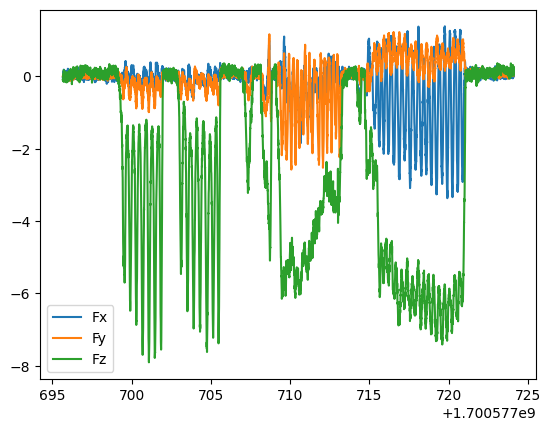

In [494]:
plt.plot(combined['t_wall'], combined['F_x'], label='Fx')
plt.plot(combined['t_wall'], combined['F_y'], label='Fy')
plt.plot(combined['t_wall'], combined['F_z'], label='Fz')
plt.legend()

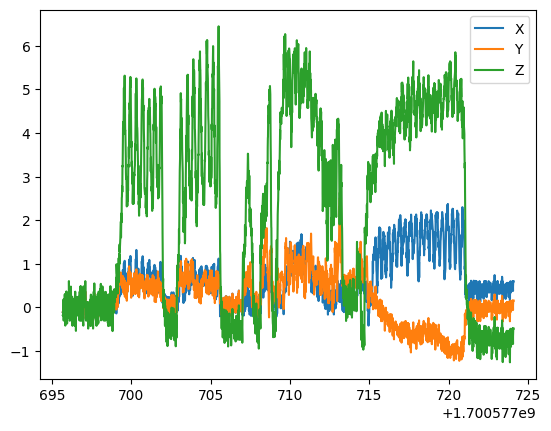

In [495]:
plt.plot(combined['t_wall'], combined['X'], label='X')
plt.plot(combined['t_wall'], combined['Y'], label='Y')
plt.plot(combined['t_wall'], combined['Z'], label='Z')
plt.legend()

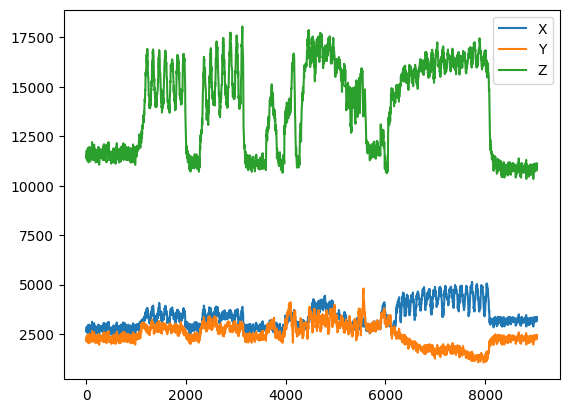

In [496]:
plt.plot(combined['X0'], label='X')
plt.plot(combined['Y0'], label='Y')
plt.plot(combined['Z0'], label='Z')
plt.legend()

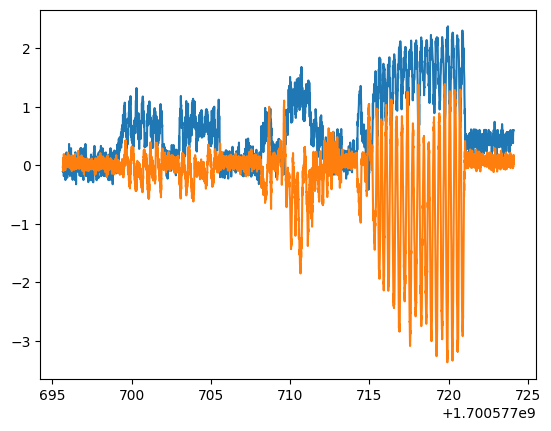

In [497]:
plt.plot(combined['t_wall'], combined['X'])
plt.plot(combined['t_wall'], combined['F_x'], label='Fz')

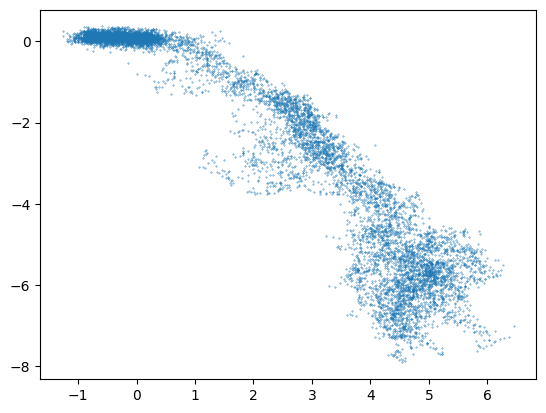

In [498]:
plt.scatter(combined['Z'], combined['F_z'], s=0.1)
Bz = lambda z: 1/(-5.5-z)**3 * 5

zs = np.linspace(-4.5, 0, 100)

# plt.plot(zs, [Bz(z) for z in zs], color='red')

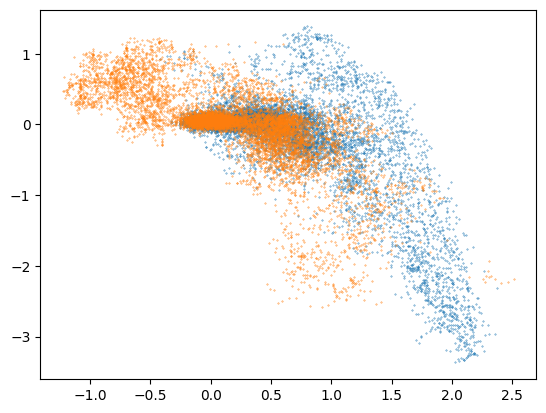

In [499]:
plt.scatter(combined['X'], combined['F_x'], s=0.1)
plt.scatter(combined['Y'], combined['F_y'], s=0.1)

### Add features

Only the magnitude (in XY plane and overall) seem to be useful

In [500]:
combined['TF_magnitude'] = np.sqrt(combined['F_x']**2 + combined['F_y']**2 + combined['F_z']**2)
combined['TF_magnitude_XY'] = np.sqrt(combined['F_x']**2 + combined['F_y']**2)

combined['sens_magnitude'] = np.sqrt(combined['X']**2 + combined['Y']**2 + combined['Z']**2)
combined['sens_magnitude_XY'] = np.sqrt(combined['X']**2 + combined['Y']**2)

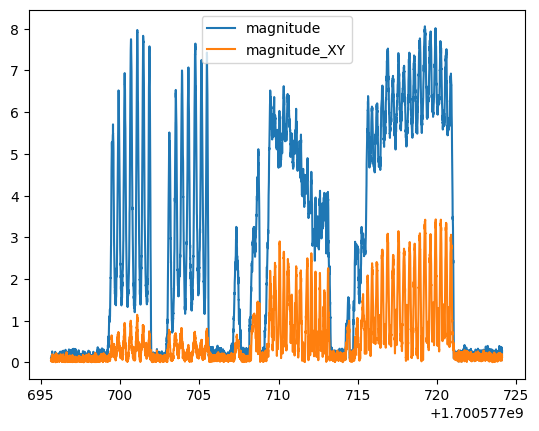

In [501]:
plt.plot(combined['t_wall'], combined['TF_magnitude'], label='magnitude')
plt.plot(combined['t_wall'], combined['TF_magnitude_XY'], label='magnitude_XY')
plt.legend()

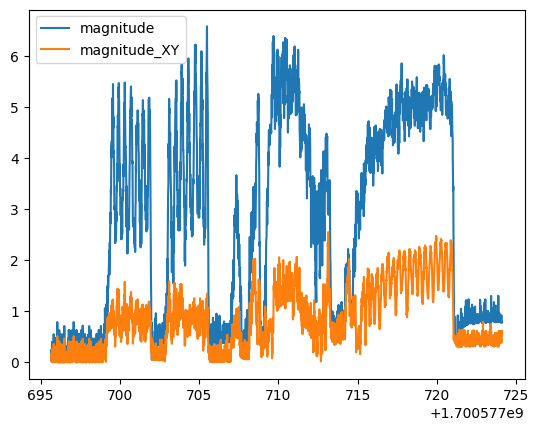

In [502]:
plt.plot(combined['t_wall'], combined['sens_magnitude'], label='magnitude')
plt.plot(combined['t_wall'], combined['sens_magnitude_XY'], label='magnitude_XY')
plt.legend()

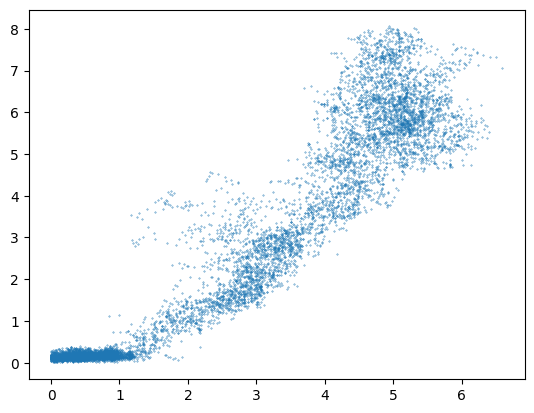

In [503]:
plt.scatter(combined['sens_magnitude'], combined['TF_magnitude'], s=0.1)

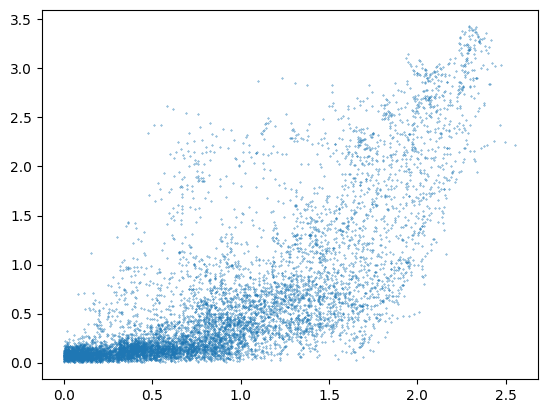

In [504]:
plt.scatter(combined['sens_magnitude_XY'], combined['TF_magnitude_XY'], s=0.1)

# Polynomial regression


In [505]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn import set_config

set_config(display='diagram')

In [524]:
from sklearn.model_selection import train_test_split

def create_pipeline_and_fit(X, Y, debug = True):

  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

  pipeline = make_pipeline(
    # RobustScaler(),
    PolynomialFeatures(degree=POLY_DEGREE, include_bias=False), 
    LinearRegression())
  
  pipeline.fit(X_train, y_train)

  if debug:
    
    print("Score: ", pipeline.score(X_test, y_test))
    print("MSE: ", mean_squared_error(y_test, pipeline.predict(X_test)))
  
  return pipeline


In [507]:
Y = combined[['F_x', 'F_y', 'F_z', 'TF_magnitude', 'TF_magnitude_XY']][1:]
X = combined[['X', 'Y', 'Z', 'sens_magnitude', 'sens_magnitude_XY']][1:]

model = create_pipeline_and_fit(X, Y)
model

Score:  0.8789065124264482
MSE:  0.13345778752987114


Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('linearregression', LinearRegression())])

In [508]:
print(model[0].get_params(True))

{'degree': 4, 'include_bias': False, 'interaction_only': False, 'order': 'C'}


In [509]:
Y_pred = model.predict(X)

/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


In [510]:
# Some functions
def plot_predictions(Y, Y_pred):
  
  subplot_index = Y.shape[1] * 100 + 11
  
  for i in range(Y.shape[1]):
    
    plt.subplot(subplot_index + i)
    plt.plot(Y[:,i], label='true')
    plt.plot(Y_pred[:,i], label='pred')

  plt.show()
  
def calculate_RMSE(Y, Y_pred):
  
  RMSE = np.zeros(Y.shape[1])
  
  for i in range(Y.shape[1]):
    RMSE[i] = np.sqrt(np.mean((Y[:,i] - Y_pred[:,i])**2))
    
  return RMSE

def calculate_error(Y, Y_pred):
    
    error = np.zeros(Y.shape)
    
    for i in range(Y.shape[1]):
      error[:, i] = np.abs(Y[:,i] - Y_pred[:,i])
      
    return error

def plot_curves(x):
  index = 1
  subplot_index = x.shape[1] * 100 + 11
  
  for i in range(x.shape[1]):
    plt.subplot(subplot_index + i)
    plt.plot(x[:, i], label='RMSE')
    
    index += 1

  plt.show()

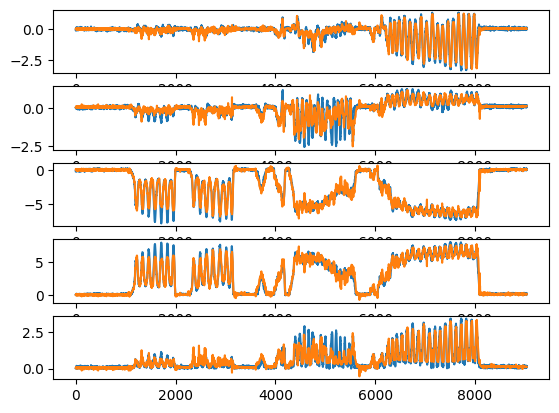

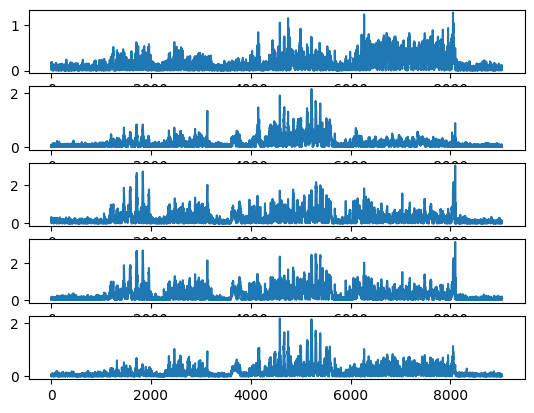

In [511]:
plot_predictions(Y.to_numpy(), Y_pred)
plot_curves(calculate_error(Y.to_numpy(), Y_pred))

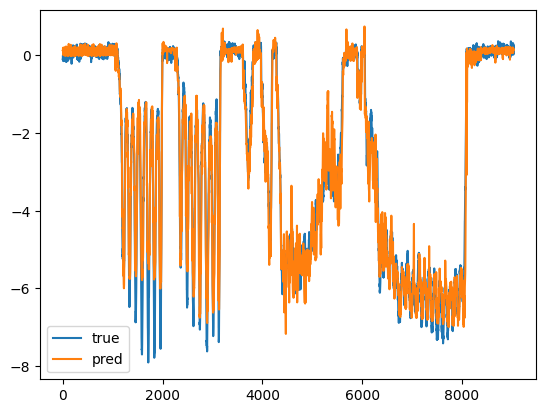

In [512]:
index = 2

plt.plot(Y.to_numpy()[:, index], label='true')
plt.plot(Y_pred[:, index], label='pred')
plt.legend()
# plt.xlim((6000,9000))

In [525]:
# Save the model
import pickle
print(X.info())
save_path = os.path.join(os.getcwd(), '..', 'models', NAME)

if not os.path.exists(save_path):
    os.makedirs(save_path)

columns = ['F_z']
for col in columns:
  
  model_path = os.path.join(save_path, col)
  model = create_pipeline_and_fit((X['Z']).to_numpy().reshape(-1, 1), Y[col])
  
  with open(model_path, 'wb') as f:
    pickle.dump(model, f)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9038 entries, 1 to 9038
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   X                  9038 non-null   float64
 1   Y                  9038 non-null   float64
 2   Z                  9038 non-null   float64
 3   sens_magnitude     9038 non-null   float64
 4   sens_magnitude_XY  9038 non-null   float64
dtypes: float64(5)
memory usage: 353.2 KB
None
Score:  0.919995002184609
MSE:  0.5210867362031855


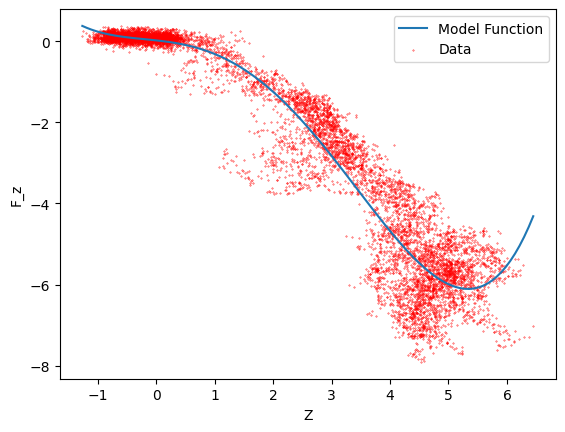

In [529]:
import matplotlib.pyplot as plt

# Define the range of x values
x_values = np.linspace(min(X['Z']), max(X['Z']), 100)

# Predict the y values using the model
y_values = model.predict(x_values.reshape(-1, 1))

# Plot the model function
plt.plot(x_values, y_values, label='Model Function')
plt.scatter(X['Z'], Y['F_z'], label='Data', s=0.1, c='r')
plt.xlabel('Z')
plt.ylabel('F_z')
plt.legend()
plt.show()
